Audio Reconstruction- Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time (t) to amplitude (A), where t is the time point, and A is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction write this in proper formating

In [51]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

from latexify import latexify
latexify(columns = 2)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


### Get the Audio File

In [28]:
from IPython.display import Audio
Audio('beat_audio.wav')

In [29]:
import torchaudio
audio, sr = torchaudio.load('./beat_audio.wav')

In [30]:
sr

44100

In [31]:
print(audio.shape)
audio = audio[0]

torch.Size([2, 227790])


In [32]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 5.16530612244898 seconds


In [33]:
audio

tensor([-4.4556e-03, -7.9346e-03, -8.3923e-03,  ...,  0.0000e+00,
         0.0000e+00,  3.0518e-05])

In [35]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

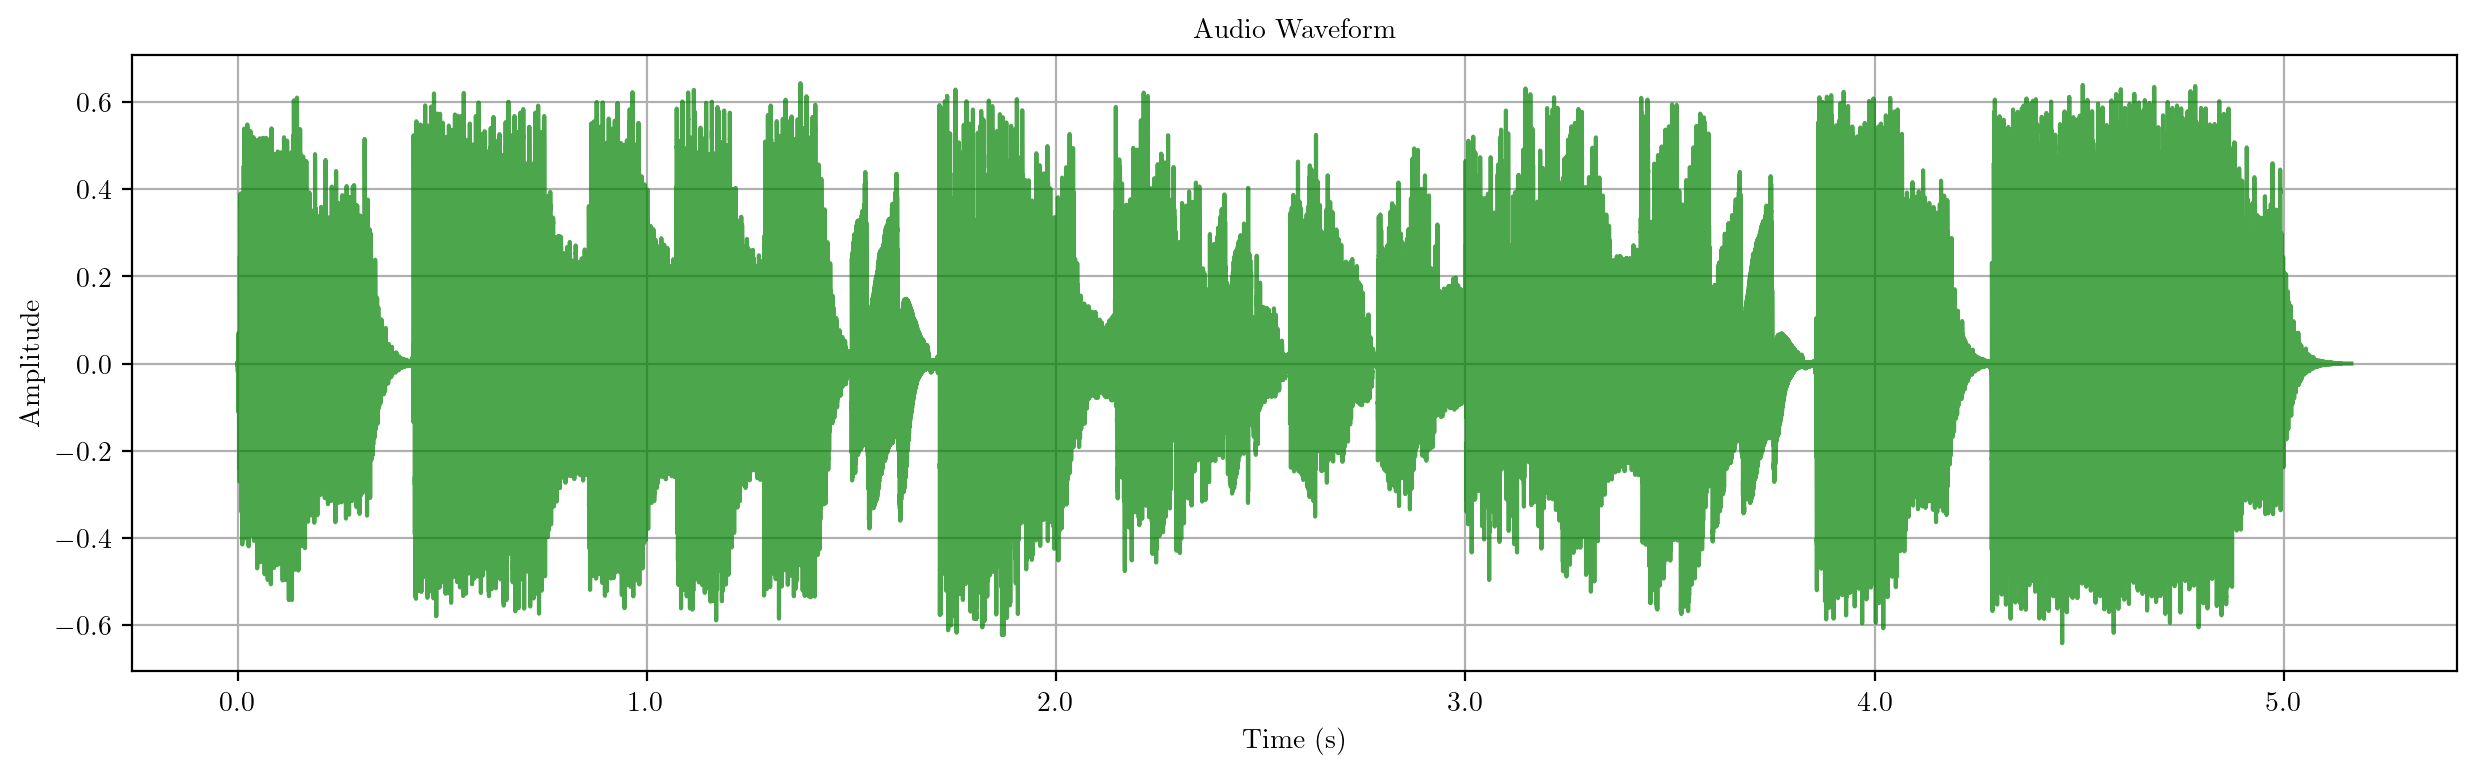

In [36]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

### Creating the Time Series $t = [-100.0, \cdots, 100.0]$ domain shifted to [-100, 100]


In [37]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([227790, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [38]:
Audio(audio, rate = sr)

In [39]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [40]:
num_features = 3000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([227790, 3000])
tensor([[ 0.0243, -0.0216, -0.0204,  ..., -0.0198, -0.0190,  0.0001],
        [ 0.0236, -0.0227, -0.0205,  ..., -0.0211, -0.0196, -0.0032],
        [ 0.0227, -0.0236, -0.0205,  ..., -0.0222, -0.0201, -0.0064],
        ...,
        [-0.0249, -0.0256, -0.0252,  ...,  0.0144,  0.0153, -0.0138],
        [-0.0243, -0.0252, -0.0252,  ...,  0.0125,  0.0160, -0.0110],
        [-0.0236, -0.0246, -0.0253,  ...,  0.0106,  0.0167, -0.0079]])


In [41]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(227790,)


### On saving the model weights and sound file

In [42]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [43]:
print(pred_audio)
print(audio)

[-0.07008182 -0.0722371  -0.07434765 ...  0.08749056  0.08869851
  0.09036136]
tensor([-4.4556e-03, -7.9346e-03, -8.3923e-03,  ...,  0.0000e+00,
         0.0000e+00,  3.0518e-05])


### Reconstruction Losses ($L_1$ and $L_2$)
$$ L_1 = \lVert \text{Reconstructed} - \text{Original} \rVert_1 $$
$$ L_2 = \lVert \text{Reconstructed} - \text{Original} \rVert_2 $$

In [44]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(84.99638, 31607.297)

## Reconstructed Audio

In [45]:
Audio(pred_audio, rate = sr)

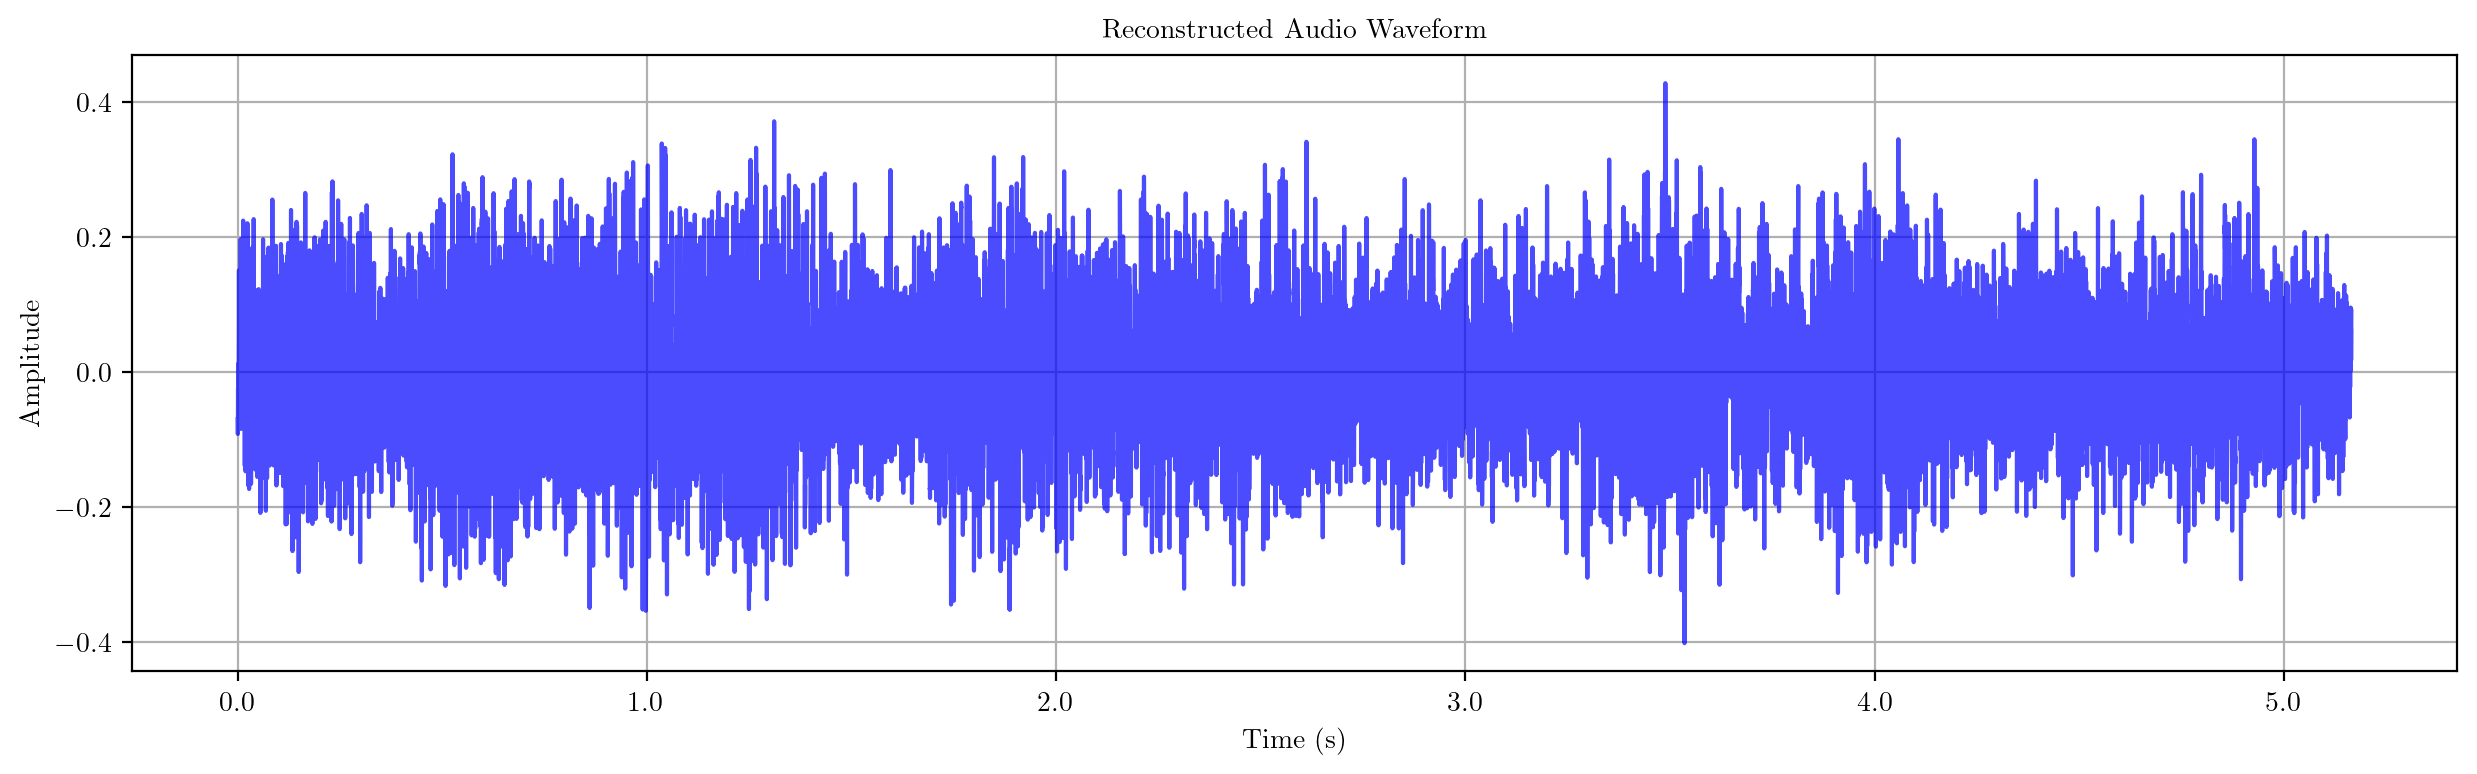

In [46]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

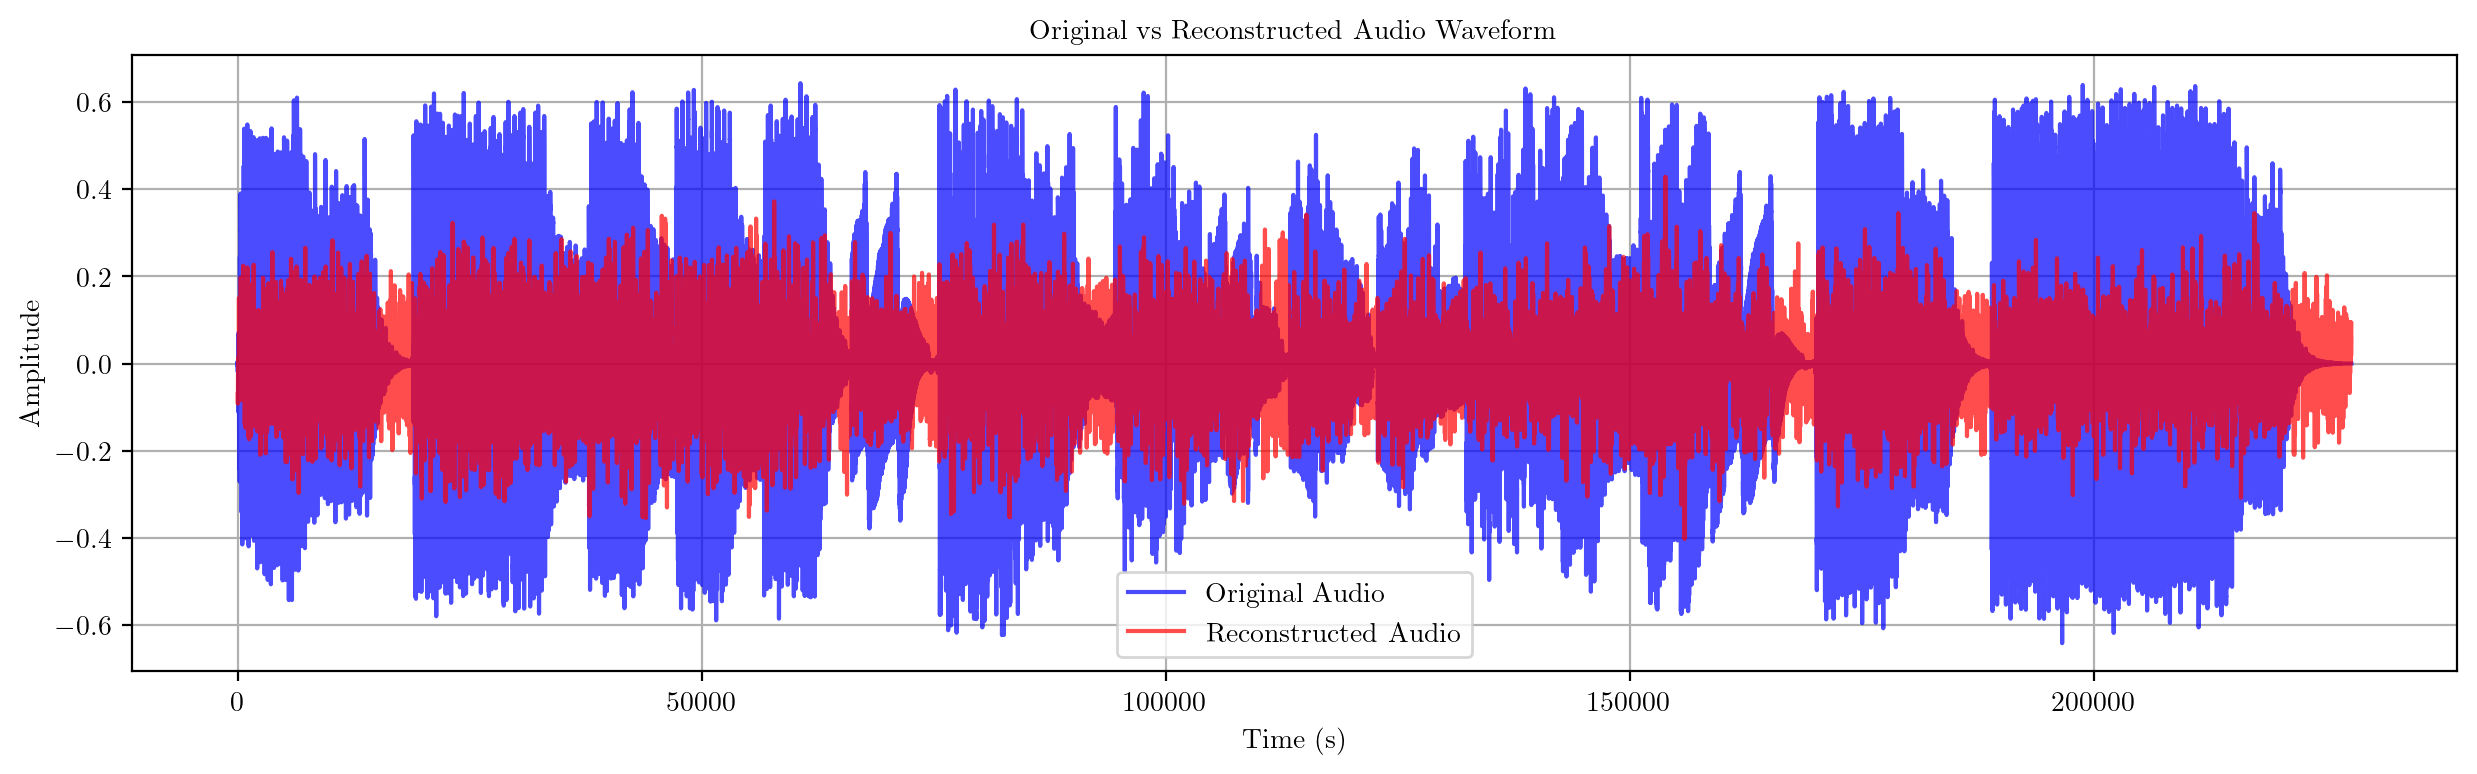

In [47]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [48]:
# Calculate RMSE
rmse = np.sqrt(np.mean((pred_audio - audio.numpy())**2))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate SNR
signal_power = np.mean(audio.numpy()**2)
noise_power = np.mean((pred_audio - audio.numpy())**2)
snr = 10 * np.log10(signal_power / noise_power)
print(f"Signal-to-Noise Ratio (SNR): {snr} dB")

Root Mean Squared Error (RMSE): 0.17808742821216583
Signal-to-Noise Ratio (SNR): 1.2818734347820282 dB


In [50]:
print("Original Audio:")
display(Audio(audio, rate=sr))
print("Reconstructed Audio:")
display(Audio(pred_audio, rate=sr))

Original Audio:


Reconstructed Audio:
